In [11]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
samp = np.zeros((2, 200))
samp[:,0] = np.array([-3,3])

In [103]:
def data_batch(data, batch_size, seed = 123):
    n = data.shape[0]
    p = data.shape[1]
    if n % batch_size !=0:
        print('%d data dropped during batching' % (n%batch_size))
    sample_size = (n // batch_size)*batch_size
        
    #shuffle
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batch = n//batch_size
    data = data[idx]
    data = data[:sample_size].reshape(batch_size, p, n_batch)
    return(data, n_batch)

def is_pos_def(A):
    '''function to check if matrix is positive definite'''
    return np.all(np.linalg.eigvals(A) > 0)

In [157]:
def sghmc(gradU, eps, C, Minv, theta_0, V_hat, epochs, burns, data, batch_size, seed = 123):
    
    '''Define SGHMC as dscribed in
    Stochastic Gradient Hamilton Monte Carlo, ICML 2014
    Tianqi Chen, Emily B. Fox, Carlos Guestrin.
    
    n: number of observations in data
    p: dimension of parameters
    
    Inputs:
        gradU: function with parameter(theta, X, y), gradient of U
        
        eps: learning rate
        
        C: friction matrix, with shape (p,p)
        
        Minv: Mass matrix, with shape (p,p)
        
        theta_0: initial value for sampling
        
        V_hat: estimated covariance matrix of stochastic gradient noise
        
        epochs: number of epochs to perform
        
        burns: number of epochs to drop
        
        batch_size: size of a minibatch in an iteration
        
        seed: seed for random generation, default 123
        
    
    Output:
        theta_samp: np.array sampled thetas
    '''
    
    ###Initialization and condition check###
    
    np.random.seed(seed)
    
    p = theta_0.shape[0]
    n = data.shape[0]
    
    theta_samp = np.zeros((p, epochs))
    theta_samp[:,0] = theta_0
    
    B_hat = 0.5*eps*V_hat
    sqrt_noise = la.sqrtm(2*(C-B_hat)*eps)
    
    sqrtM = la.sqrtm(la.inv(Minv))
    r = np.random.multivariate_normal(np.zeros(p), sqrtM).reshape(p, -1)
    
    dat_batch, nbatches = data_batch(data, batch_size)
    for i in range(epochs-1):
        
        theta = theta_samp[:,i]
        r = np.random.multivariate_normal(np.zeros(p), sqrtM).reshape(p, -1)
        
        for batch in range(nbatches):
            theta = theta + (eps*Minv@r).ravel()
            gradU_batch = gradU(theta, dat_batch[:,:, batch], n, batch_size).reshape(p, -1)
            r = r-eps*gradU_batch - eps*C@Minv@r \
                + np.random.multivariate_normal(np.zeros(p), sqrt_noise).reshape(p, -1)
            
        theta_samp[:,i+1] = theta
            
    return theta_samp[:, burns:]

## Example 1 on paper pg6 (fig 1)

$U(\theta) = 2\theta^2+\theta^4$  
$\nabla U(\theta) = -4\theta + 4\theta^3$  
$\nabla\tilde{U}(\theta) = \nabla U(\theta)+\mathcal{N}(0,4) = -4\theta + 4\theta^3 + \mathcal{N}(0,4)$ 

In [138]:
np.random.seed(123)
n = 100
x = np.zeros((100, 1))
theta_0 = np.array([0.0])
C = np.eye(1)*2*eps
p = theta_0.shape[0]
eps = 0.1
V = np.eye(1)*4
batch_size = 1
epochs = 2000
burns = 100

In [156]:
def gradU_noise(theta, x, n, batch_size):
    '''noisy gradient from paper fig1'''
    return -4*theta + 4*theta**3 + np.random.normal(0,2)

In [143]:
sim = sghmc(gradU_noise, eps, C, np.eye(p), theta_0, V, epochs, burns, x, batch_size)
sim

array([[-1.35262126, -1.11322584, -1.2745749 , ..., -0.87724834,
         0.30854791, -1.15068284]])

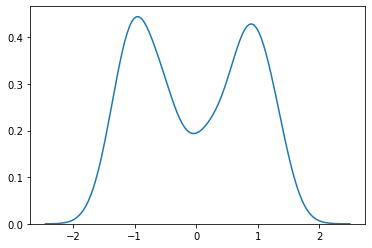

In [144]:
sns.kdeplot(sim[0,:])

## Mixture of Normals

sampling model: $X \sim \frac{1}{2}\mathcal{N}(\mu_1, 1) + \frac{1}{2}\mathcal{N}(\mu_2, 1)$  

prior: $\mu_1, \mu_2 \sim \mathcal{N}(0, 10)$

In [101]:
import sys
!{sys.executable} -m pip install autograd #install package to calculate gradient

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=48961 sha256=838ef1a398c60c5c3e8345f30643c0f0aa4260d40065952731b1c61ea62acd69
  Stored in directory: /home/jovyan/.cache/pip/wheels/b2/a5/3c/929b91003a3b75a175ccba7cef35200a1890cdb46903f18072
Successfully built autograd


In [174]:
from autograd import jacobian
import autograd.numpy as np

In [175]:
mu = np.array([-3,3]).reshape(2,1)

In [176]:
def lprior(theta):
    return (-1/(2*10))*theta.T@theta

def ldatap(theta, x):
    return np.log(0.5 * np.exp(-0.5*(theta[0]-x)**2) + 0.5* np.exp(-0.5*(theta[1]-x)**2))

def U(theta, x, n, batch_size):
    return -lprior(theta) - (n/batch_size)*sum(ldatap(theta, x))

gradU = jacobian(U, argnum = 0)

In [182]:
np.random.seed(123)
n = 200
x = np.r_[
    np.random.normal(mu[0], 1, n),
    np.random.normal(mu[1], 1, n)].reshape(-1,1)

theta_0 = np.array([0, 0])
eps = 0.01
V_hat = np.eye(2)
C = np.eye(2)
epochs = 200
burns = 100
batch_size = 80

In [183]:
sim_mn = sghmc(gradU, eps, C, np.eye(2), theta_0, V_hat, epochs, burns, x, batch_size)

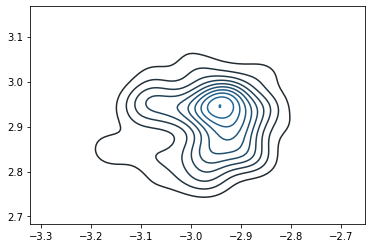

In [184]:
sns.kdeplot(sim_mn[0,:],sim_mn[1,:])

In [2]:
import sys
!{sys.executable} -m pip install pyhmc

  Created wheel for pyhmc: filename=pyhmc-0.1.2-cp36-cp36m-linux_x86_64.whl size=545282 sha256=8221cbbe86ad196582b8c440bd833d269c66c4a39d5beb884d021431588229e3
  Stored in directory: /home/jovyan/.cache/pip/wheels/2c/03/3d/1e7a82362e40143e2e4c075d735bcbc4d9427b17ae8c8efcd0
Successfully built pyhmc


In [3]:
from pyhmc import hmc

## Example 1, pyhmc

In [49]:
def logprob(theta):
    logp = 2 * theta**2 - theta**4
    grad= 4 * theta - 4 * theta**3
    return logp, grad

theta0=np.array([0])

In [52]:
samp=hmc(logprob,x0=theta0,n_samples=10000)

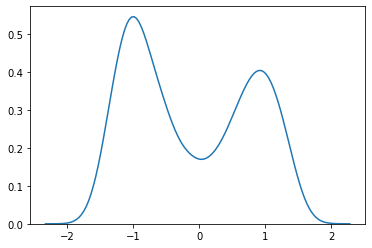

In [53]:
sns.distplot(samp,kde=True,hist=False)

## Example 2, pyhmc

In [18]:
def logprob(theta):
        logp = np.sum(U(theta, x=x, n=n, batch_size=n))
        gradu = gradU(theta, x=x, n=n, batch_size=n).reshape((-1,))
        return logp, gradu

In [24]:
sim_hmc = hmc(logprob, x0=mu.reshape(-1), n_samples=100, epsilon=0.01)

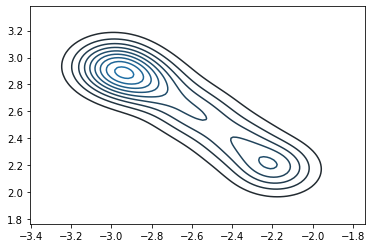

In [29]:
sns.kdeplot(sim_hmc[:,0], sim_hmc[:,1])